In [164]:
import skimage
import matplotlib.pyplot as plt
import numpy as np
import keras
import tensorflow as tf
import lib

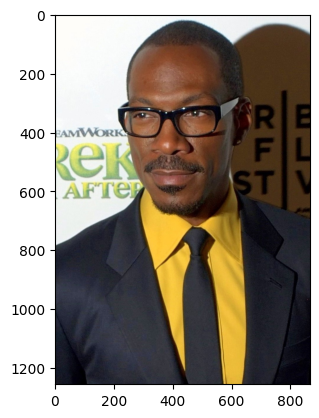

In [165]:
eddie = skimage.io.imread("eddie hi-res.png")[:,:,:3]
plt.imshow(eddie)
bin_size = 30

# Convertir eddie en Lab
# Séparer L et ab
# "Discrétiser" ab avec des blocs de taille 10

In [166]:
eddie_Lab = skimage.color.rgb2lab(eddie)
eddie_L = eddie_Lab[:,:,0]
eddie_ab = eddie_Lab[:,:,1:]

In [167]:
eddie_ab[0,0]

array([-0.36596866,  2.02988601])

In [168]:
eddie_ab_quantized = (eddie_ab//bin_size)*bin_size + bin_size//2
eddie_ab_quantized

array([[[-15.,  15.],
        [-15.,  15.],
        [-15.,  15.],
        ...,
        [ 15., -15.],
        [ 15., -15.],
        [ 15., -15.]],

       [[-15.,  15.],
        [-15.,  15.],
        [-15.,  15.],
        ...,
        [ 15., -15.],
        [ 15., -15.],
        [ 15., -15.]],

       [[-15.,  15.],
        [-15.,  15.],
        [-15.,  15.],
        ...,
        [ 15., -15.],
        [ 15., -15.],
        [ 15., -15.]],

       ...,

       [[ 15., -15.],
        [ 15., -15.],
        [ 15., -15.],
        ...,
        [ 15., -15.],
        [ 15., -15.],
        [ 15.,  15.]],

       [[ 15., -15.],
        [ 15., -15.],
        [ 15., -15.],
        ...,
        [ 15., -15.],
        [ 15., -15.],
        [ 15.,  15.]],

       [[ 15., -15.],
        [ 15., -15.],
        [ 15., -15.],
        ...,
        [ 15., -15.],
        [ 15., -15.],
        [ 15.,  15.]]])

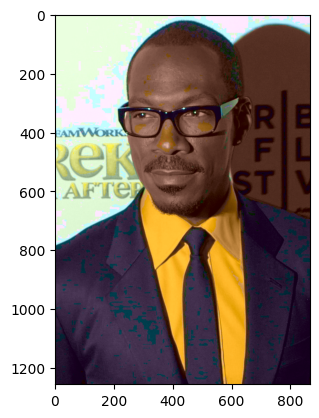

In [169]:
plt.imshow(skimage.color.lab2rgb(np.stack([eddie_L, eddie_ab_quantized[:,:,0], eddie_ab_quantized[:,:,1]], axis=2)))

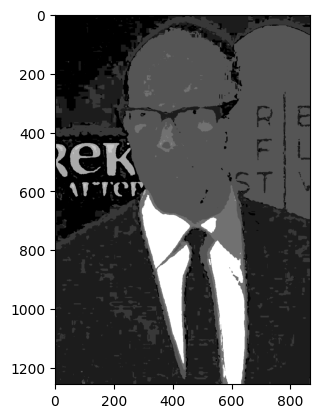

In [170]:
ab_to_label_dict = {}
label_to_ab_dict = {}
last_label = 0

def ab_pixel_to_label(ab_pixel):
    global last_label
    ab_tuple = (ab_pixel[0], ab_pixel[1])
    if ab_tuple not in ab_to_label_dict.keys():
        ab_to_label_dict[ab_tuple] = last_label
        label_to_ab_dict[last_label] = ab_pixel
        last_label += 1
    return ab_to_label_dict[ab_tuple]

def label_to_ab_pixel(label):
    return label_to_ab_dict[label]

def ab_image_to_label(image):
    return np.apply_along_axis(ab_pixel_to_label, axis=2, arr=image)

def label_image_to_ab(image):
    return np.apply_along_axis(label_to_ab_pixel, axis=2, arr=image)

plt.imshow(ab_image_to_label(eddie_ab_quantized), cmap="gray")

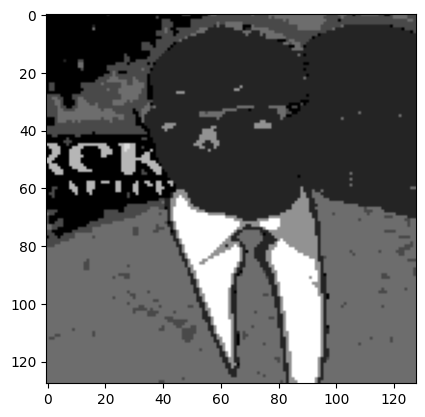

In [171]:
eddie_ab_quantized_squeeze = (skimage.transform.resize((skimage.transform.resize(eddie_ab, (128, 128))//bin_size)*bin_size + bin_size//2, eddie_ab_quantized.shape)//bin_size)*bin_size +bin_size//2
plt.imshow(ab_image_to_label(skimage.transform.resize(eddie_ab, (128, 128))//bin_size)*bin_size + bin_size//2, cmap="gray")

In [172]:
def rassembler_L_et_ab(L, ab):
    a = ab[:,:,0]
    b = ab[:,:,1]
    return skimage.color.lab2rgb(np.stack([L, a, b], axis=2))

def reconstituer_image(L, labeled_image):
    return rassembler_L_et_ab(L, label_image_to_ab(labeled_image))

/tmp/ipykernel_14504/3792249955.py:4: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 74 negative Z values that have been clipped to zero
  return skimage.color.lab2rgb(np.stack([L, a, b], axis=2))


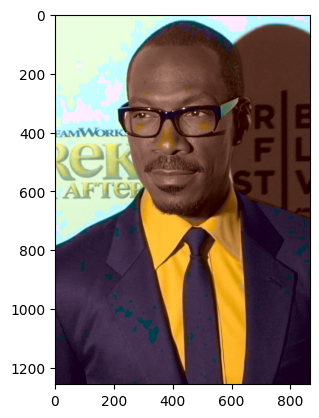

In [173]:
plt.imshow(rassembler_L_et_ab(eddie_L, eddie_ab_quantized_squeeze))

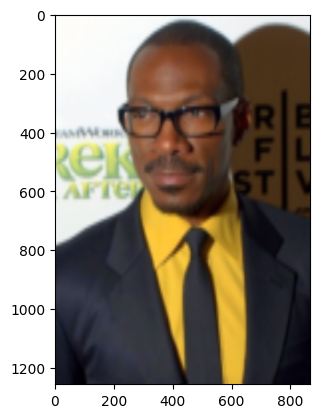

In [174]:
plt.imshow(skimage.transform.resize(skimage.transform.resize(eddie, (128, 128)), eddie.shape))

In [175]:
dataset = keras.utils.image_dataset_from_directory("my_celebs", labels=None, )

Found 33062 files.


In [176]:
import PIL
from matplotlib import cm

colors_bruno = [
"#000000",
"#9D9D9D",
"#FFFFFF",
"#BE2633",
"#E06F8B",
"#493C2B",
"#A46422",
"#EB8931",
"#F7E26B",
"#2F484E",
"#44891A",
"#A3CE27",
"#1B2632",
"#005784",
"#31A2F2",
"#B2DCEF"]

colors_bruno_rgb = []

for c in colors_bruno:
    colors_bruno_rgb.append(PIL.ImageColor.getcolor(c, "RGB"))


# np.array([colors_bruno_rgb])
# palette = PIL.Image.fromarray(np.astype(np.array([colors_bruno_rgb]), np.uint8)).convert("P", colors=16)
# print(palette)
# palette = PIL.Image.fromarray(np.zeros((1, 1, 1), dtype=np.uint8)).convert("P", colors=2)
# im = PIL.Image.fromarray(eddie)
# hop = im.quantize(colors = 12, palette=palette, dither=PIL.Image.Dither.NONE)
# hop

# np.array([[[0]*255]])

In [178]:
from PIL import Image
import numpy as np

def hex_to_rgb(hex_colors):
    """Convert a list of hex color strings to a list of RGB tuples."""
    return [tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5)) for hex_color in hex_colors]

def quantize_image_to_palette(image_path, output_path, hex_palette):
    """
    Quantizes an image to use only the colors from a given palette.
    
    Parameters:
        image_path (str): Path to the input image.
        output_path (str): Path to save the quantized output image.
        hex_palette (list): List of hex color strings representing the palette.
    """
    # Load the image
    image = Image.open(image_path).convert("RGB")
    
    # Convert palette to RGB tuples
    rgb_palette = hex_to_rgb(hex_palette)
    
    # Create a PIL-compatible palette (flattened RGB values)
    pil_palette = [value for rgb in rgb_palette for value in rgb] + [0] * (768 - len(rgb_palette) * 3)

    # Create a new image with the given palette
    palette_image = Image.new("P", (1, 1))
    palette_image.putpalette(pil_palette)

    # Quantize the image to the palette
    quantized_image = image.quantize(palette=palette_image)

    # Save the quantized image
    quantized_image.save(output_path)
    print(f"Quantized image saved to {output_path}")

# Example usage
# hex_colors = [
#     "#FF5733", "#33FF57", "#3357FF", "#FF33A1", "#A133FF", 
#     "#33FFF5", "#F5FF33", "#FF8C33", "#8C33FF", "#FF338C",
#     "#33FF8C", "#338CFF", "#F5A133", "#A1F533", "#5733FF", 
#     "#FF5733"
# ]

quantize_image_to_palette("eddie hi-res.png", "output_image.png", colors_bruno)

Quantized image saved to output_image.png
